# Домашнее задание к уроку "Обучение сверточной сети на практике"

Требуется обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Решение необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3. Датасет находится по ссылке https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import resnet50
from glob import glob
import os.path
import os
import re
import json
from IPython.display import Image

Определим размер изображения на входе модели и подготовим функции обработки изображений и генерирования тензоров для обучения модели

In [2]:
IMG_SIZE = (224, 224)  # размер входного изображения сети
INPUT_SHAPE = (224, 224, 3)

train_files = glob('cats_dog_data/train/*.jpg')
test_files = glob('cats_dog_data/test/*.jpg')

In [3]:
def load_image(image_path, target_size=None, mode='train'):
    """ Функция чтения изображения с диска и его предобработки для ResNet
    
    Параметры
    ---------
    image_path : str
      Путь к изображению на диске
    target_size : tuple
      Кортеж размера изображения в формате (HEIGHT, WIDTH).
      По умолчанию None. Если указаны значение, то будет сделать resize
    mode : str
      Режим генерации изображения. Если значение равно train,
      то функция будет генерировать изображения с рандомной обрезкой 
      и переворотами налево и направо для уменьшения переобучения модели. 
      Для валидации и теста необходимо отключать рандомизацию.
    """

    mode = str(mode).strip().lower()

    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img)
    img = tf.cast(img, np.float32)

    if target_size:
        img = tf.image.resize(img, target_size)

    if mode == 'train':
      img = tf.image.random_flip_left_right(img)
      img_width = img.shape[1]
      img_heigth = img.shape[0]
      img_layers = img.shape[2]
      crop_coeff = 0.9
      img = tf.image.random_crop(img, size=(int(img_heigth*crop_coeff), int(img_width*crop_coeff), img_layers))
      img = tf.image.resize(img, (img_heigth, img_width))
    
    img = resnet50.preprocess_input(img)
    return img


def fit_generator(files, target_size=None, batch_size=5, mode='train'):
    """ Генератор данных для обучения модели
    
    Параметры
    ---------
    files : list
      Список путей к фотографиями
    target_size : tuple
      Кортеж размера изображения в формате (HEIGHT, WIDTH).
      По умолчанию None. Если указаны значение, то будет сделать resize
    batch_size : int
      Размер батча
    mode : str
      Режим генерации изображения. Если значение равно train,
      то функция будет генерировать изображения с рандомной обрезкой 
      и переворотами налево и направо для уменьшения переобучения модели. 
      Для валидации и теста необходимо отключать рандомизацию.
      
    Результат
    ---------
    x, y : np.array, np.array
    """
    
    if batch_size < 1:
        batch_size = 1
        
    while True:
        
        batch_start = 0
        batch_end = batch_size
        
        np.random.shuffle(files)
        
        for _ in range(len(files)//batch_size):
            
            batch_img = []
            batch_class = []
            
            for image_path in files[batch_start:batch_end]:
                
                image_name = os.path.basename(image_path)
                label = image_name.split(".")[0].lower().strip()
                assert label in ('cat', 'dog'), 'метка фото не является котом или собакой'
                
                category = 1. if label == 'dog' else 0.
                img = load_image(image_path, target_size=target_size, mode=mode)
                
                batch_img.append(img)
                batch_class.append(category)
                
            batch_start += batch_size
            batch_end += batch_size
            
            yield np.array(batch_img), np.array(batch_class)
                

def predict_generator(files, target_size):
  """ функция-генератор загрузки тестовых изображений с диска
    
  Параметры
  ---------
  files : list
    Список путей к фотографиями
  target_size : tuple
    Кортеж размера изображения в формате (HEIGHT, WIDTH).
    По умолчанию None. Если указаны значение, то будет сделать resize

  Результат
  ---------
  image : np.array
  """
  while True:
      for path in files:
          yield np.array([load_image(path, target_size=target_size, mode='test')])

Проверим, как работает генератор изображения для одной и той же фотографии в режиме обучения

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

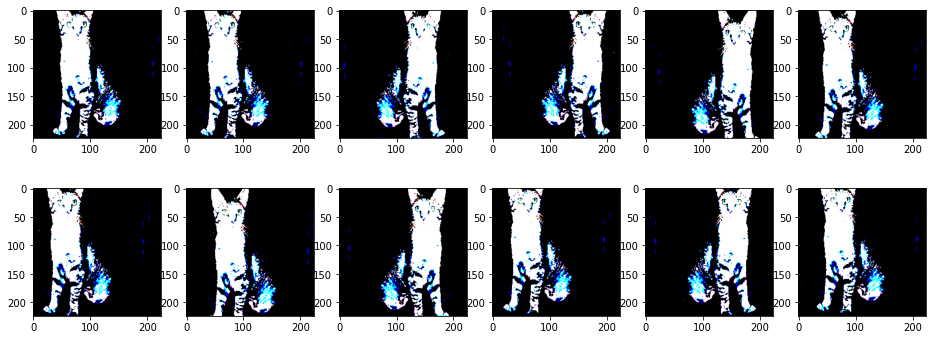

In [4]:
show_img_count = 12
plot_col = 6
plot_rows = show_img_count // plot_col if show_img_count % plot_col == 0 else show_img_count // plot_col + 1
fig, axes = plt.subplots(plot_rows, plot_col, figsize=(16,plot_rows*3))

for ax in list(axes.flatten()):
  img, _ = next(fit_generator(train_files[5:6], batch_size=1, target_size=IMG_SIZE, mode='train'))
  img = img[0]
  ax.imshow(img)
plt.show()

Как видно, происходит случайный поворот изображения и небольшая случайная подрезка. Такой механизм генерации для обучения может помочь снизить переобучение модели.

Теперь построим нашу модель на базе ResNet50.

In [5]:
features = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
for layer in features.layers:
    layer.trainable = False
feature_tensor = features.layers[-1].output

output = tf.keras.layers.Flatten()(feature_tensor)
output = tf.keras.layers.Dense(units=32, activation='relu', 
                               kernel_initializer=tf.keras.initializers.glorot_uniform)(output)
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(units=64, activation='relu', 
                               kernel_initializer=tf.keras.initializers.glorot_uniform)(output)
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(units=128, activation='relu', 
                               kernel_initializer=tf.keras.initializers.glorot_uniform)(output)
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(units=256, activation='relu', 
                               kernel_initializer=tf.keras.initializers.glorot_uniform)(output)
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(units=1, activation='sigmoid', 
                               kernel_initializer=tf.keras.initializers.glorot_uniform)(output)

model = tf.keras.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/catdogs_resnet_best_val_loss.hdf5',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    mode="min",
    restore_best_weights=False,
)

Подготовим данные для обучения и валидации. Для валидации возьмем 30% изображений. Для обучения настроим генератор на рандомизацию изображений с помощью параметра mode='train' . Для валидации и теста рандмозизацию выключим.

In [7]:
batch_size = 32
val_samples = int(len(train_files) * 0.3)

validation_data = train_files[:val_samples]
train_data = train_files[val_samples:]

gen_train = fit_generator(validation_data, batch_size=batch_size, 
                          target_size=IMG_SIZE, mode='train')
gen_valid = fit_generator(train_data, batch_size=batch_size, 
                          target_size=IMG_SIZE, mode='valid')
steps_per_epoch = int(len(train_data) // batch_size)
validation_steps = int(len(validation_data) // batch_size)

Приступаем к обучению модели

In [8]:
"""
model_history = model.fit(gen_train, epochs=20, steps_per_epoch=steps_per_epoch, 
                          validation_data=gen_valid, validation_steps=validation_steps,
                          callbacks=[checkpoint, early_stopping])
model_history = model_history.history
"""

# Загрузим уже обученную модель
# Требуется предварительно скачать файл
# https://drive.google.com/file/d/1746q31fF2GAMI55jx9xs6bT4jcii0uce
model.load_weights("catdogs_resnet_best_val_loss.hdf5")
with open('model_stat_history.json', 'r', encoding='utf-8') as file:
  model_history = json.loads(file.read())

Построим графики сравнения функции ошибок на обучении и валидации

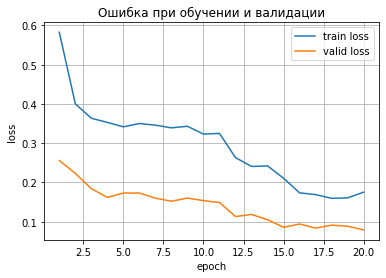

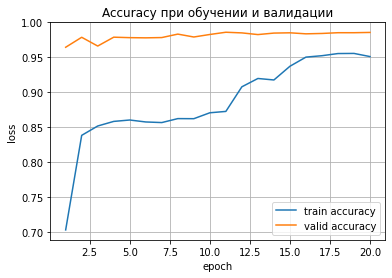

In [9]:
epochs = np.arange(1, len(model_history['loss'])+1)
plt.plot(epochs, model_history['loss'], label='train loss')
plt.plot(epochs, model_history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Ошибка при обучении и валидации')
plt.grid()
plt.show()

plt.plot(epochs, model_history['accuracy'], label='train accuracy')
plt.plot(epochs, model_history['val_accuracy'], label='valid accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Accuracy при обучении и валидации')
plt.grid()
plt.show()

По графику ошибки заметна одна особенность: ошибка при валидации на каждом этапе смещена в сторону уменьшения ошибки. Это связано с тем, что валидацию мы производим на изображениях без операции рандомизации. А при обучении в каждой эпохе на вход подаются рандомизированные изображения. Для модели фактически эти изображения являются в некоторой степени неизвестными и отличными от изображений в предыдущих эпохах. При этом мы видим, что ошибка на тесте и валидации уменьшается соразмерно. Это говорит о том, что в модели не происходит переобучения.

Сгенерируем предсказания для тестовой выборки и продемонстрируем на фотографиях результаты.

In [10]:
pred_data_gen = predict_generator(test_files, target_size=IMG_SIZE)
test_pred_sigmoid = model.predict(pred_data_gen, steps=len(test_files))
test_pred_label = ['dog' if sigmoid > 0.5 else 'cat' for sigmoid in test_pred_sigmoid]

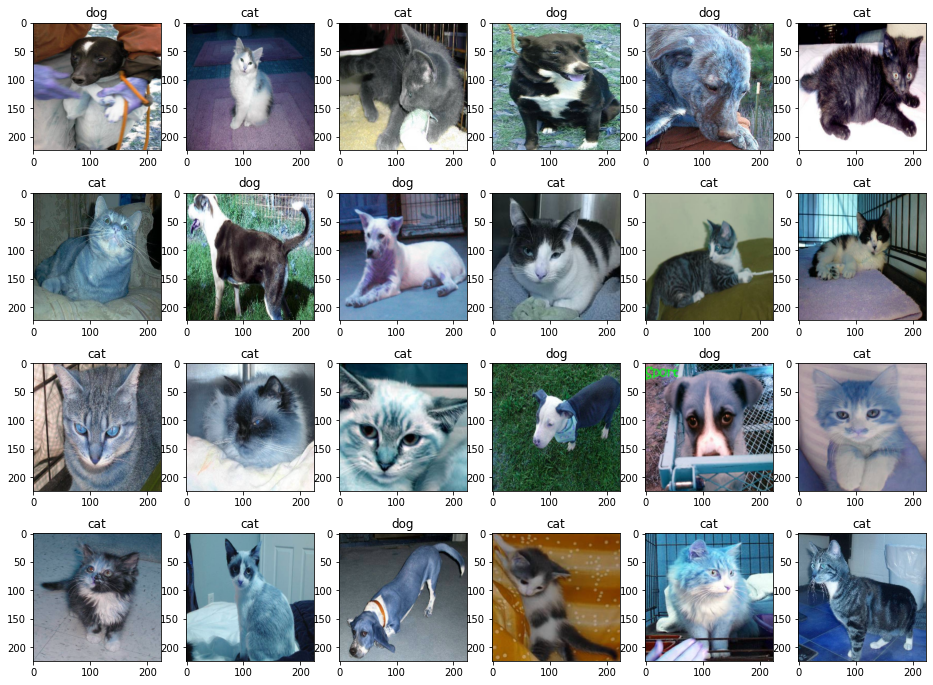

In [11]:
show_img_count = 24
plot_col = 6
plot_rows = show_img_count // plot_col if show_img_count % plot_col == 0 else show_img_count // plot_col + 1
fig, axes = plt.subplots(plot_rows, plot_col, figsize=(16,plot_rows*3))

for test_file, label, ax in zip(test_files[:show_img_count], test_pred_label[:show_img_count], list(axes.flatten())):
    img = cv2.imread(test_file)
    img = cv2.resize(img, IMG_SIZE)
    ax.imshow(img)
    ax.set_title(label)
    
plt.show()

Теперь подготовим файл для проверки score в соревновании на kaggle (https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

In [12]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred_sigmoid):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

Результаты работы на Kaggle

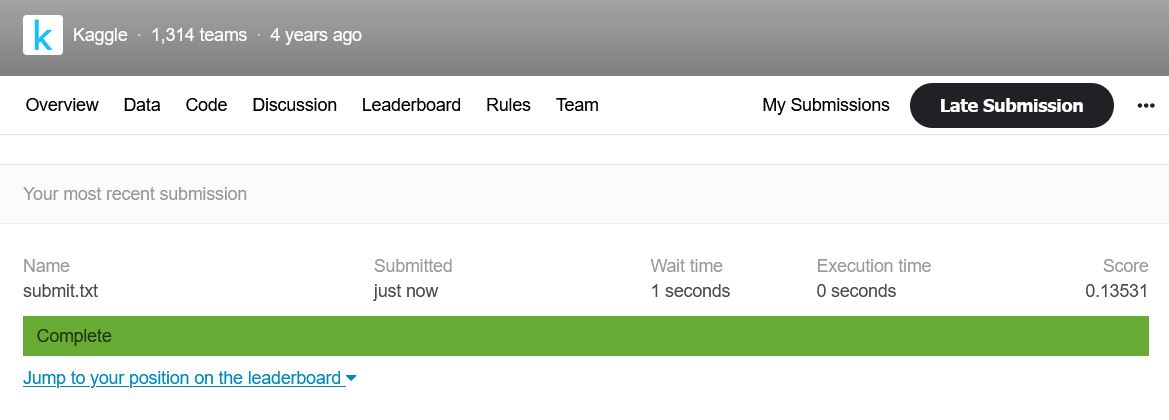

In [13]:
Image("kaggle_result.jpg")